In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('diabetes2.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.shape

(768, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


#### There are no null values in the data, so we dont need to remove any rows

<AxesSubplot:>

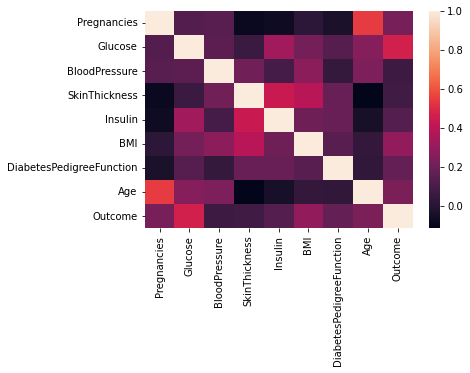

In [5]:
sns.heatmap(df.corr())

#### We can see that the data is not highly correlated, so there is no need to drop any columns

#### Standardising the input data using StandardScaler

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[df.columns[:-1]] = scaler.fit_transform(df[df.columns[:-1]])
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995,1
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672,0
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584,1
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549,0
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496,1


#### Splitting data into train validation and test sets with seed 0

In [7]:
train = df.sample(frac=0.7, random_state=0)
val = df.drop(train.index).sample(frac=0.666, random_state=0)
test = df.drop(np.concatenate((train.index, val.index)))

print('Training set size:', train.shape[0])
print('Validation set size:', val.shape[0])
print('Testing set size:', test.shape[0])

Training set size: 538
Validation set size: 153
Testing set size: 77


#### Splitting data into input and output

In [8]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]
X_val = val.iloc[:, :-1]
y_val = val.iloc[:, -1]
X_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]

# Part 1

## Performing Logistic regression

In [9]:
def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

class LogisticRegression():
    def __init__(self, alpha, iters):
        self.alpha = alpha
        self.iters = iters
    
    def bgd(self, x, y, resume):
        # number of training samples and number of features
        m, n = x.shape
        # initialising weights and bias
        if(not resume):
            self.w = np.zeros(n)
            self.b = 0
        
        self.losses = []
        # iterating until error is negligible or max number of iterations is reached
        for i in range(self.iters):
            self.update(x, y, 'bgd')
            hx = sigmoid(x.dot(self.w) + self.b)
            self.losses.append(loss(hx, y))
            if(resume):
                if(i>2):
                    if(self.losses[-1]>self.losses[-2]):
                        print('early stopping')
                        break

    def sgd(self, x, y, resume):
        # number of training samples and number of features
        m, n = x.shape
        # initialising weights and bias
        if(not resume):
            self.w = np.zeros(n)
            self.b = 0
        
        self.losses = []
        # iterating until error is negligible or max number of iterations is reached
        for i in range(self.iters):
            for j in range(0, m):
                self.update(x.iloc[j], y.iloc[j], 'sgd')
            hx = sigmoid(x.dot(self.w) + self.b)
            self.losses.append(loss(hx, y))
            if(resume):
                if(i>2):
                    if(self.losses[-1]>self.losses[-2]):
                        print('early stopping')
                        break
    
    def update(self, x, y, opt):
        x = np.array(x)
        y = np.array(y)
        m = len(x)
        hx = sigmoid(x.dot(self.w) + self.b)
        # gradients for weights and bias
        dw = ( (x.T).dot(hx - y) ) * (1/m)
        db = ( np.sum(hx - y) ) * (1/m)
        
        # updating the weights
        self.w = self.w - self.alpha * dw
        self.b = self.b - self.alpha * db

    def predict(self, x):
        hx = sigmoid(x.dot(self.w) + self.b)
        y_pred = np.where(hx > 0.5, 1, 0)
        return y_pred
    # class ends here

def loss(y_pred, y):
    # adding small value so log foes not become 0
    epsilon = 1e-10
    # calculates loss for the given predictions
    loss = -np.mean(y*np.log(y_pred + epsilon) + (1-y)*np.log(1-y_pred + epsilon))
    return loss

# A

## BGD loss vs iterations

### On training set

In [10]:
# lr = 0.1, iters = 500
model = LogisticRegression(0.1, 500)
model.bgd(X_train, y_train, False)

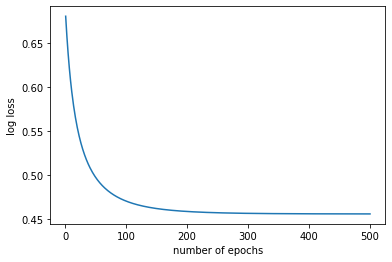

In [11]:
plt.plot(np.arange(1, model.iters+1), model.losses)
plt.xlabel('number of epochs')
plt.ylabel('log loss')
plt.show()

In [12]:
accuracy = np.sum(model.predict(X_train)==y_train) / len(y_train)
print('Our model correctly predicts outcome', accuracy*100, '% of the time on the training set')

Our model correctly predicts outcome 79.182156133829 % of the time on the training set


### On validation set

In [13]:
# lr = 0.1, iters = 500
model.bgd(X_val, y_val, True)

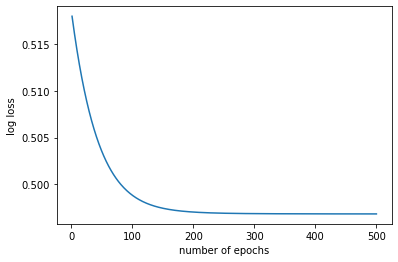

In [14]:
plt.plot(np.arange(1, model.iters+1), model.losses)
plt.xlabel('number of epochs')
plt.ylabel('log loss')
plt.show()

In [15]:
accuracy = np.sum(model.predict(X_train)==y_train) / len(y_train)
print('Our model correctly predicts outcome', accuracy*100, '% of the time on the validation set')

Our model correctly predicts outcome 77.88104089219331 % of the time on the validation set


#### On both the sets it takes around 200 epochs for our model to converge
#### The accuracy is lower and final loss is higher for validation set as the number of samples is lower in validation set

## SGD loss vs iterations

### On training set

In [16]:
# lr = 0.1, iters = 25
model = LogisticRegression(0.1, 25)
model.sgd(X_train, y_train, False)

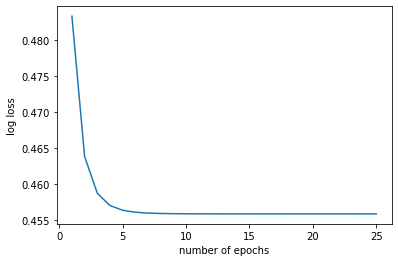

In [17]:
plt.plot(np.arange(1, model.iters+1), model.losses)
plt.xlabel('number of epochs')
plt.ylabel('log loss')
plt.show()

In [18]:
accuracy = np.sum(model.predict(X_train)==y_train) / len(y_train)
print('Our model correctly predicts outcome', accuracy*100, '% of the time on the training set')

Our model correctly predicts outcome 78.62453531598513 % of the time on the training set


### On validation set

In [19]:
# lr = 0.1, iters = 25
model.sgd(X_val, y_val, True)

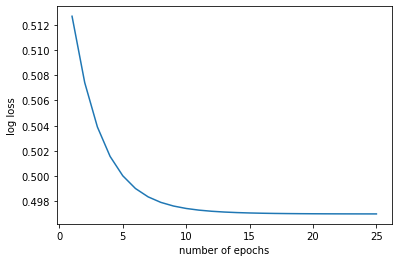

In [20]:
plt.plot(np.arange(1, model.iters+1), model.losses)
plt.xlabel('number of epochs')
plt.ylabel('log loss')
plt.show()

In [21]:
accuracy = np.sum(model.predict(X_train)==y_train) / len(y_train)
print('Our model correctly predicts outcome', accuracy*100, '% of the time on the validation set')

Our model correctly predicts outcome 77.69516728624535 % of the time on the validation set


#### On both the sets it takes around 10 epochs for our model to converge
#### SGD converges in much lesser number of epochs than BGD since the weights are updated with each input point

# B

## BGD



Learning rate = 0.01


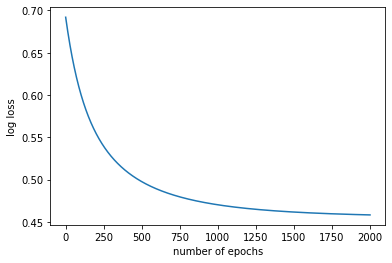

Our model correctly predicts outcome 72.72727272727273 % of the time on the testing set


Learning rate = 0.0001


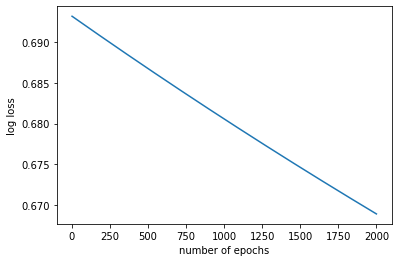

Our model correctly predicts outcome 75.32467532467533 % of the time on the testing set


Learning rate = 10


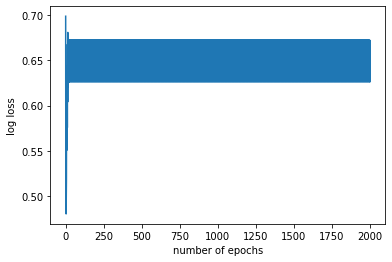

Our model correctly predicts outcome 67.53246753246754 % of the time on the testing set


In [22]:
def graph(model):
    plt.plot(np.arange(1, model.iters+1), model.losses)
    plt.xlabel('number of epochs')
    plt.ylabel('log loss')
    plt.show()

def accuracy(model):
    accuracy = np.sum(model.predict(X_test)==y_test) / len(y_test)
    print('Our model correctly predicts outcome', accuracy*100, '% of the time on the testing set')

# iters = 2000
lrs = [0.01, 0.0001, 10]
for lr in lrs:
    model = LogisticRegression(lr, 2000)
    model.bgd(X_train, y_train, False)
    print('\n\nLearning rate =', lr)
    graph(model)
    accuracy(model)

#### 0.01 learning rate is slower to converge than the original 0.1 taken by us, but it does reach convergence after a few thousand iterations
#### 0.0001 is too low for the learning rate, it will take an unfeasibly large number of iterations to converge.
#### 10 is too high, after some iterations the loss starts bouncing between 2 high loss values and does not reduce any further, it cannot reduce the loss to an acceptable level

## SGD



Learning rate = 0.01


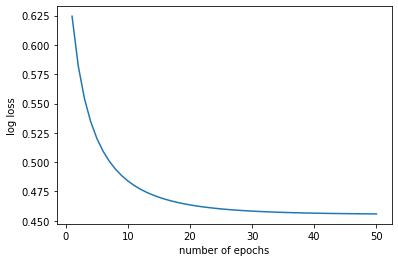

Our model correctly predicts outcome 72.72727272727273 % of the time on the testing set


Learning rate = 0.0001


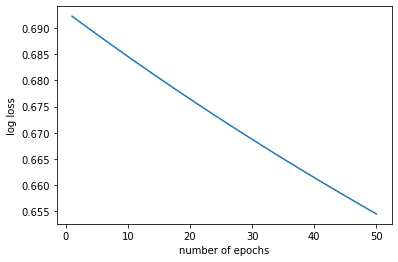

Our model correctly predicts outcome 75.32467532467533 % of the time on the testing set


Learning rate = 10


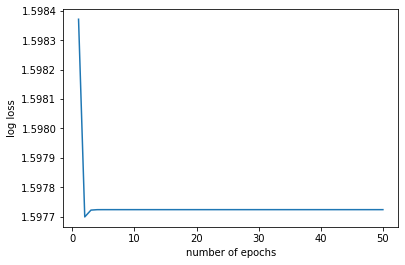

Our model correctly predicts outcome 71.42857142857143 % of the time on the testing set


In [23]:
def graph(model):
    plt.plot(np.arange(1, model.iters+1), model.losses)
    plt.xlabel('number of epochs')
    plt.ylabel('log loss')
    plt.show()

def accuracy(model):
    accuracy = np.sum(model.predict(X_test)==y_test) / len(y_test)
    print('Our model correctly predicts outcome', accuracy*100, '% of the time on the testing set')

# iters = 50
lrs = [0.01, 0.0001, 10]
for lr in lrs:
    model = LogisticRegression(lr, 50)
    model.sgd(X_train, y_train, False)
    print('\n\nLearning rate =', lr)
    graph(model)
    accuracy(model)

#### 0.01 learning rate is slower to converge than the original 0.1 taken by us, but it does reach convergence after about 30 iterations
#### 0.0001 is too low for the learning rate, it will take an infeasibly large number of iterations to converge.
#### 10 is too high, after some iterations the loss starts bouncing between 2 high loss values and does not reduce any further, it cannot reduce the loss to an acceptable level

# C

In [24]:
def confusionMatrix(y, yh):
    # n is number of classes
    y = np.array(y)
    yh = np.array(yh)
    n = len(np.unique(y))
    mat = np.zeros((n, n))
    for i in range(len(y)):
        mat[y[i]][yh[i]] += 1
    return mat

## BGD

In [25]:
# lr = 0.05, iters = 500
model = LogisticRegression(0.05, 500)
model.bgd(X_train, y_train, False)

In [26]:
cmat = confusionMatrix(np.array(y_test), model.predict(X_test))
print('Confusion matrix:\n', cmat)

Confusion matrix:
 [[42. 11.]
 [10. 14.]]


In [27]:
accuracy = (cmat[0][0] + cmat[1][1]) / np.sum(cmat)
precision = (cmat[1][1]) / (cmat[1][1] + cmat[0][1])
recall = (cmat[1][1]) / (cmat[1][1] + cmat[1][0])
f1score = 2* (precision * recall) / (precision + recall)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1score:', f1score)

Accuracy: 0.7272727272727273
Precision: 0.56
Recall: 0.5833333333333334
F1score: 0.5714285714285714


## SGD

In [28]:
# lr = 0.05, iters = 25
model = LogisticRegression(0.05, 25)
model.sgd(X_train, y_train, False)

In [29]:
cmat = confusionMatrix(np.array(y_test), model.predict(X_test))
print('Confusion matrix:\n', cmat)

Confusion matrix:
 [[42. 11.]
 [10. 14.]]


In [30]:
accuracy = (cmat[0][0] + cmat[1][1]) / np.sum(cmat)
precision = (cmat[1][1]) / (cmat[1][1] + cmat[0][1])
recall = (cmat[1][1]) / (cmat[1][1] + cmat[1][0])
f1score = 2* (precision * recall) / (precision + recall)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1score:', f1score)

Accuracy: 0.7272727272727273
Precision: 0.56
Recall: 0.5833333333333334
F1score: 0.5714285714285714


# Part 2

#### 0.01 is chosen as the learning rate, with maximum 50 iterations

In [31]:
from sklearn.linear_model import SGDClassifier
from io import StringIO
import sys

## A

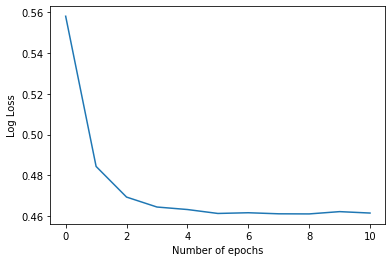

In [32]:
old_stdout = sys.stdout
sys.stdout = mystdout = StringIO()
model = SGDClassifier(learning_rate='constant', eta0=0.01, loss='log', max_iter=50, verbose=1)
model.fit(X_train, y_train)
sys.stdout = old_stdout
loss_history = mystdout.getvalue()
loss_list = []
for line in loss_history.split('\n'):
    if(len(line.split("loss: ")) == 1):
        continue
    loss_list.append(float(line.split("loss: ")[-1]))
plt.figure()
plt.plot(np.arange(len(loss_list)), loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Log Loss")
plt.show()
plt.close()

#### SGDClassifier and our model both have the same kind of plot, and the final loss value is also similar for both

## B

In [33]:
print('SGDClassifier converged in', model.n_iter_, 'iterations')

SGDClassifier converged in 11 iterations


#### sklearn SGDClassifer converges in around 10 epochs while our algorithm took more than 25 epochs, this may be because the sklearn model may use some extra optimisations that we have not

## C

In [34]:
cmat = confusionMatrix(y_test, model.predict(X_test))
accuracy = (cmat[0][0] + cmat[1][1]) / np.sum(cmat)
precision = (cmat[1][1]) / (cmat[1][1] + cmat[0][1])
recall = (cmat[1][1]) / (cmat[1][1] + cmat[1][0])
f1score = 2* (precision * recall) / (precision + recall)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1score:', f1score)

Accuracy: 0.7272727272727273
Precision: 0.56
Recall: 0.5833333333333334
F1score: 0.5714285714285714


#### Confusion matrix for both the SGDClassifier and our model is the same, so both perform similarly in terms of accuracy, precision, recall and f1score